In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping
from conditional_rate_matching import results_path
from torchvision.utils import make_grid

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_Cifar import experiment_cifar10_config
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import (ConstantThermostatConfig, 
                                                                                         PeriodicThermostatConfig,
                                                                                         ExponentialThermostatConfig,
                                                                                         PolynomialThermostatConfig,
                                                                                         PlateauThermostatConfig
                                                                                         )

def generate_samples(trained_model, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 3, 32, 32)
    x_t = x_t.view(-1, x_t.shape[1], 3, 32, 32)
    return x_1, x_t, t

def cifar_noise_bridge(path, 
                       x_input, 
                       num_timesteps=1000,  
                       time_epsilon=0.0,
                       num_img=5,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    img_1, img_hist, time_steps = generate_samples(path, x_input[:num_img], num_timesteps=num_timesteps,  time_epsilon=time_epsilon, device=x_input.device)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))
    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    img_1 = img_1.long()  # Normalize to [0, 1] if necessary
    img_hist = img_hist.long() # Normalize to [0, 1] if necessary

    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze().transpose(1, 2, 0) , cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze().transpose(1, 2, 0) , cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/bridge_example.png')


def configure_thermostat(config, thermostat, params):
    thermostat_config_classes = {
        'exponential': ExponentialThermostatConfig,
        'constant': ConstantThermostatConfig,
        'periodic': PeriodicThermostatConfig,
        'polynomial': PolynomialThermostatConfig,
        'plateau': PlateauThermostatConfig
    }
    
    thermostat_config = thermostat_config_classes[thermostat]()
    gamma, *other_params = params
    thermostat_config.gamma = gamma

    if hasattr(thermostat_config, 'max'):
        thermostat_config.max = other_params[0]
    if hasattr(thermostat_config, 'exponent'):
        thermostat_config.exponent = other_params[1]
    if hasattr(thermostat_config, 'slope'):
        thermostat_config.slope = other_params[1]
    if hasattr(thermostat_config, 'shift'):
        thermostat_config.shift = other_params[2]

    config.thermostat = thermostat_config


# def cifar_conditional_bridge(source, target, thermostat="constant", 
#                              thermostat_params=(.1, 0), num_timesteps=100,
#                              num_timesteps_displayed=10, save_path=None):
    
#     config = experiment_cifar10_config()
#     configure_thermostat(config, thermostat, thermostat_params)

#     crm = CRM(config)
#     crm.config.pipeline.number_of_steps = num_timesteps
#     crm.config.pipeline.num_intermediates = num_timesteps_displayed

#     rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1, 3*32*32), t)
#     img_1, img_hist, _, time = TauLeaping(crm.config, rate_model, source.view(-1, 3*32*32), forward=True)
#     img_1 = img_1.long().view(source.shape[0], 1, 3, 32, 32)
#     img_hist = img_hist.long().view(-1, num_timesteps_displayed, 3, 32, 32)

#     print(img_hist.shape, img_1.shape, time.shape)

#     img_path = torch.cat([img_hist, img_1], dim=0)
#     image_grid(img_path, nrow=num_timesteps_displayed+1)


def cifar_conditional_bridge(source, 
                             target, 
                             thermostat="constant", 
                             thermostat_params=(.1,0),
                             figsize=None, 
                             num_timesteps=100,
                             num_timesteps_displayed=10,
                             save_path=None):
    
    config = experiment_cifar10_config()
    
    if thermostat == 'exponential':
        config.thermostat = ExponentialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'constant':
        config.thermostat = ConstantThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
    elif thermostat == 'periodic':
        config.thermostat = PeriodicThermostatConfig()
        config.thermostat.gamma= thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'polynomial':
        config.thermostat = PolynomialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.exponent = thermostat_params[1]
    elif thermostat == 'plateau':
        config.thermostat = PlateauThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.slope = thermostat_params[1]
        config.thermostat.shift = thermostat_params[2]

    crm = CRM(config)
    crm.config.pipeline.number_of_steps = num_timesteps
    crm.config.pipeline.num_intermediates = num_timesteps_displayed

    rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1, 3*32*32), t)
    img_1, img_hist, _ , time = TauLeaping(crm.config, rate_model, source.view(-1, 3*32*32), forward=True)


    num_img = source.shape[0]

    img_0 = source.long().view(-1, 3, 32, 32)
    img_1 = img_1.long().view(-1, 3, 32, 32)
    img_hist = img_hist.long().view(-1, num_timesteps_displayed, 3, 32, 32)

    _, axs = plt.subplots(num_img, num_timesteps_displayed+1, figsize=(num_timesteps_displayed+1, num_img) if figsize is None else figsize)

    for j in range(num_timesteps_displayed):
        for i in range(num_img):
            img = img_hist[i, j, :].detach().cpu().numpy().transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if i==0: axs[i, j].set_title(r'$t={0}$'.format(round(time[j].item(),2)))
    
    for i in range(num_img):
        img = img_1[i].detach().cpu().numpy().transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)
        axs[i, num_timesteps_displayed+1].imshow(img)
        axs[i, num_timesteps_displayed+1].axis('off')

    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path + '/conditional_markov_example.png')



def get_cifar10_test_samples(trained_model, 
                            which = 'source', # 'source' or 'target
                            class_label=None, 
                            sample_size=800, 
                            device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()

    for batch in source if which == 'source' else target:
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 3, 32, 32)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)



def image_grid(sample, save_path='.', num_img=5, nrow=8, figsize=(10,10)):
    _, _= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    sample = sample / sample.max()
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()

# EMNIST $\to$ MNIST

constant thermostat with: $\gamma=0.5$:

source data:

Files already downloaded and verified
Files already downloaded and verified


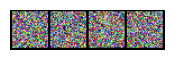

In [22]:
path = "crm_cifar10"
NOISE = get_cifar10_test_samples(path, which='source', sample_size=4, device="cuda:0")
image_grid(NOISE, nrow=4, num_img=4, figsize=(2,1))


target data:

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


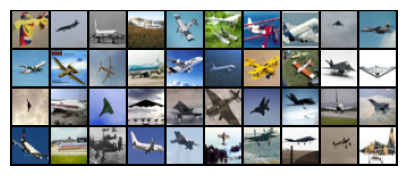

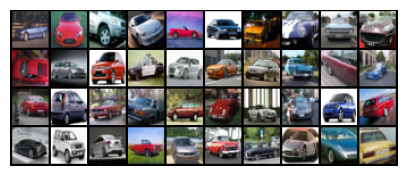

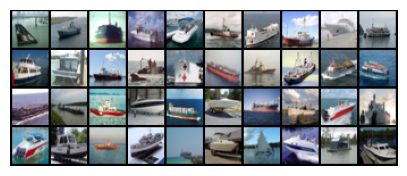

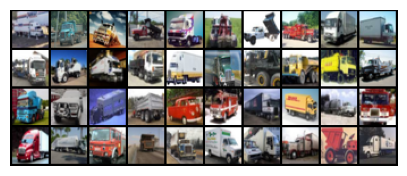

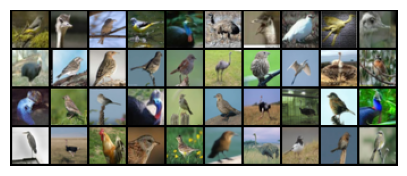

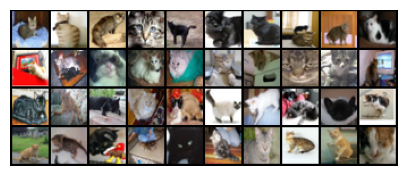

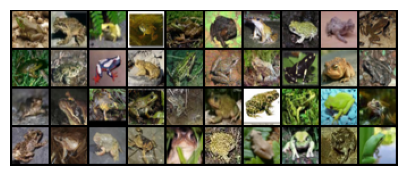

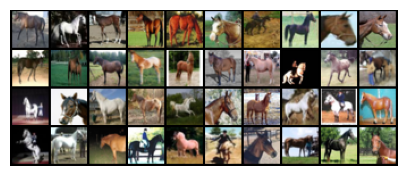

In [ ]:
path = "crm_cifar10"
AIRPLANE = get_cifar10_test_samples(path, which='target', class_label=0, sample_size=40, device="cuda:0")
CAR = get_cifar10_test_samples(path, which='target', class_label=1, sample_size=40, device="cuda:0")
SHIP = get_cifar10_test_samples(path, which='target', class_label=8, sample_size=40, device="cuda:0")
TRUCK = get_cifar10_test_samples(path, which='target', class_label=9, sample_size=40, device="cuda:0")

BIRD = get_cifar10_test_samples(path, which='target', class_label=2, sample_size=40, device="cuda:0")
CAT = get_cifar10_test_samples(path, which='target', class_label=3, sample_size=40, device="cuda:0")
FROG = get_cifar10_test_samples(path, which='target', class_label=6, sample_size=40, device="cuda:0")
HORSE = get_cifar10_test_samples(path, which='target', class_label=7, sample_size=40, device="cuda:0")

image_grid(AIRPLANE, nrow=10, num_img=40, figsize=(5,5))
image_grid(CAR, nrow=10, num_img=40, figsize=(5,5))
image_grid(SHIP, nrow=10, num_img=40, figsize=(5,5))
image_grid(TRUCK, nrow=10, num_img=40, figsize=(5,5))

image_grid(BIRD, nrow=10, num_img=40, figsize=(5,5))
image_grid(CAT, nrow=10, num_img=40, figsize=(5,5))
image_grid(FROG, nrow=10, num_img=40, figsize=(5,5))
image_grid(HORSE, nrow=10, num_img=40, figsize=(5,5))

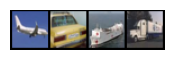

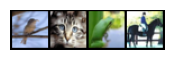

In [24]:

TRANSPORT = torch.cat([AIRPLANE[-7].unsqueeze(0), 
                       CAR[-1].unsqueeze(0), 
                       SHIP[6].unsqueeze(0), 
                       TRUCK[-1].unsqueeze(0)], dim=0)
  
image_grid(TRANSPORT, nrow=4, num_img=4, figsize=(2,1))

ANIMALS = torch.cat([BIRD[2].unsqueeze(0), 
                     CAT[3].unsqueeze(0), 
                     FROG[-1].unsqueeze(0), 
                     HORSE[-7].unsqueeze(0)], dim=0)

image_grid(ANIMALS, nrow=4, num_img=4, figsize=(2,1))

# Markov interpolators

Files already downloaded and verified
Files already downloaded and verified


1000it [00:04, 209.28it/s]


IndexError: index 21 is out of bounds for axis 1 with size 21

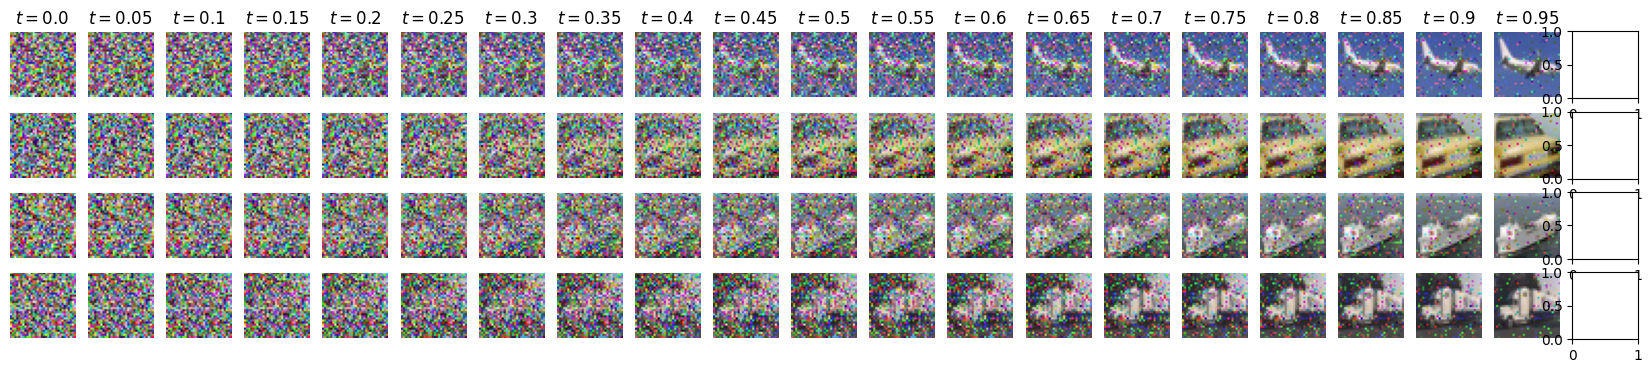

In [26]:
cifar_conditional_bridge(NOISE, TRANSPORT, thermostat="constant", thermostat_params=(1e-4, 0.0), num_timesteps=1000, num_timesteps_displayed=20)


Files already downloaded and verified
Files already downloaded and verified


1000it [00:04, 204.46it/s]


IndexError: index 21 is out of bounds for axis 1 with size 21

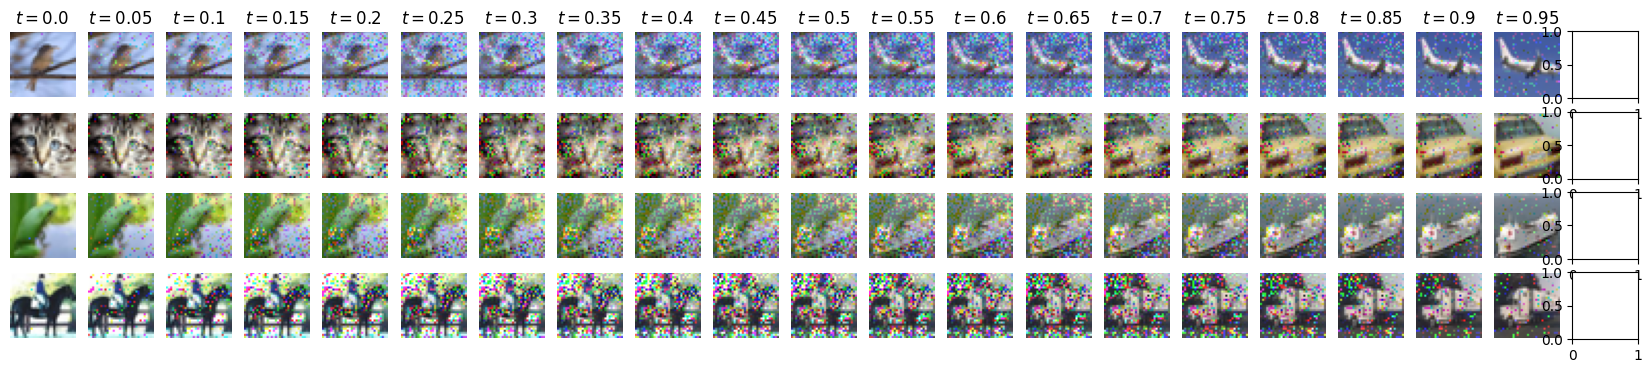

In [27]:
cifar_conditional_bridge(ANIMALS, TRANSPORT, thermostat="constant", thermostat_params=(1e-4, 0.0), num_timesteps=1000, num_timesteps_displayed=20)


## Generated images from CRM

In [ ]:
path = "crm_cifar10_gamma_0.01"
noise = get_cifar10_test_samples(path, which='source', sample_size=16, device="cuda:0")
image_grid(noise, nrow=4, num_img=16, figsize=(3,3))

In [ ]:
path = "crm_cifar10_gamma_0.01"
samples,_ , _ = generate_samples(path, noise, num_timesteps=100, time_epsilon=0.0, device="cuda:0")
image_grid(samples, num_img=16, nrow=4, figsize=(3,3))

In [ ]:
cifar_noise_bridge(path, 
                x_input=noise, 
                num_timesteps=100,  
                time_epsilon=0.,
                num_img=5,
                num_timesteps_displayed=20,
                save_path=None)